# Task: Model the dynamics of gender in intro CS


In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Import libraries


import sys
sys.path.append('tools/')

import numpy as np
import pandas as pd
import matplotlib.pyplot as pyplt
import seaborn as sns
import tools
import pickle
   
pyplt.style.use('ggplot')

## Exploring the Data

Let's go ahead and read in the student dataset first.


In [3]:
dataset = tools.preprocess()

In [4]:
tools.dataDescr()

UC Berkeley Intro CS Student dataset

Notes
------
Data Set Characteristics:

Number of Instances:882

Attribute Information:

Self reported attitudes about CS
- atcs_1 I like to use computer science to solve problems.
- atcs_2 I can learn to understand computing concepts.
- atcs_3 I can achieve good grades (C or better) in computing courses.
- atcs_4 I do not like using computer science to solve problems.
- atcs_5 I am confident that I can solve problems by using computation.
- atcs_6 The challenge of solving problems using computer science appeals to me.
- atcs_7 I am comfortable with learning computing concepts.
- atcs_8 I am confident about my abilities with regards to computer science.
- atcs_9 I do think I can learn to understand computing concepts.

Gendered belief about CS ability
- atcsgender_1 Women are less capable of success in CS than men.
- atcsgender_2 Women are smarter than men.
- atcsgender_3 Men have better math and science abilities than women.

Career driven beliefs

In [5]:
tools.dataLookUp('atct_8')

I know how to write a computer program to solve a problem.


In [7]:
dataset = dataset.query('gender == "Female" or gender == "Male"')
dataset = dataset.reset_index(drop=True)


print '{:d}{:20}{:d}{:20}'.format(len(dataset.query('gender == "Male"')), ' male students, and ',
                                  len(dataset.query('gender == "Female"')),
                                  ' female students consented to participate in this study')
                        

494 male students, and 388 female students consented to participate in this study


## Preprocess Data

### Preprocess feature columns
To prepare our data for classification, we need to devise a scheme to transform all features into numeric data. This dataset as several non-numeric columns that need converting. Many of them are simply `yes`/`no`, e.g. `prcs_2`. We can reasonably convert these into `1`/`0` (binary) values. For the columns whose values are `Nan`, we will convert these to `0`. 


**Note**: These generated columns are sometimes called _dummy variables_, and we will use the [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) function to perform this transformation.

In [8]:
# Preprocess feature columns
def preprocess_features(X):
    outX = pd.DataFrame(index=X.index)  # output dataframe, initially empty

    # Check each column
    for col, col_data in X.iteritems():
        # If data type is non-numeric, try to replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['Yes', 'No'], [1, 0])
        # Note: This should change the data type for yes/no columns to int

        # If still non-numeric, convert to one or more dummy variables
        if col_data.dtype == object:
            # e.g. 'reason' => 'reason_class_Interested' , 'reason_class_Other'
            col_data = pd.get_dummies(col_data, prefix=col)

        outX = outX.join(col_data)  # collect column(s) in output dataframe
        outX.fillna(0, inplace=True) # make sure all NaN <missing> values are set to 0

    return outX



In [9]:
dataset = preprocess_features(dataset)
print "Processed feature columns ({}):- {}".format(len(dataset.columns), list(dataset.columns))


Processed feature columns (47):- ['atcs_1', 'atcs_2', 'atcs_3', 'atcs_4', 'atcs_5', 'atcs_6', 'atcs_7', 'atcs_8', 'atcs_9', 'atcsgender_1', 'atcsgender_2', 'atcsgender_3', 'atcsjob_1', 'atcsjob_2', 'atct_1', 'atct_2', 'atct_3', 'atct_4', 'atct_5', 'atct_6', 'atct_7', 'atct_8', 'blg_1', 'blg_2', 'blg_3', 'blg_4', 'classmtr', 'clet_1', 'clet_2', 'cltrcmp_1', 'cltrcmp_2', 'gender_Female', 'gender_Male', 'grade_B or above', 'grade_B or below', 'mtr_1', 'mtr_2', 'mtr_3', 'prcs_1', 'prcs_2', 'prcs_3', 'prcs_4', 'prcs_5', 'prepared', 'priorcs10', 'reason_class_Interested', 'reason_class_Other']


### Preprocess feature columns - Rename columns

There are some columns that have spaces in their names, these makes it difficult for the tree plotting algorithms that we will be using later to graph these features. As a result, we will change these spaces to hypens.

In [10]:
dataset.rename(columns = {'grade_B or above':'grade_B_or_above'}, inplace = True)
dataset.rename(columns = {'grade_B or below':'grade_B_or_below'}, inplace = True)

### Scaling
Linearly scale each attribute to the range [0, 1].



In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

df_scaled = pd.DataFrame(scaler.fit_transform(dataset), columns=dataset.columns)
dataset = df_scaled
dataset.tail()


,atcs_1,atcs_2,atcs_3,atcs_4,atcs_5,atcs_6,atcs_7,atcs_8,atcs_9,atcsgender_1,...,mtr_3,prcs_1,prcs_2,prcs_3,prcs_4,prcs_5,prepared,priorcs10,reason_class_Interested,reason_class_Other
877,1.00,1.00,1.00,0.00,1.00,1.00,1.00,1.00,1.00,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.00,0.0,1.0,0.0
878,0.00,0.50,0.25,1.00,0.00,0.00,0.00,0.00,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,1.0
879,1.00,1.00,1.00,0.25,0.75,1.00,1.00,0.75,1.00,0.0,...,0.0,1.0,1.0,0.0,1.0,1.0,1.00,0.0,0.0,0.0
880,1.00,1.00,0.75,0.25,0.50,0.75,0.50,0.50,0.75,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,1.0,0.0
881,0.75,0.75,0.50,0.25,0.25,1.00,0.75,0.50,1.00,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.25,0.0,1.0,0.0


### Frequency Distribution

Create the dimension that we are interested in investigating.

In [50]:
mtr = ['mtr_1', 'mtr_2', 'mtr_3'] # CS Mentors
prcs = ['prcs_1', 'prcs_2', 'prcs_3', 'prcs_4', 'prcs_5'] # Prior CS Exposure
atcs = ['atcs_1', 'atcs_2', 'atcs_3', 'atcs_4', 'atcs_5', 
        'atcs_6', 'atcs_7', 'atcs_8', 'atcs_9']# self reported attitude about CS competency
atct = ['atct_1', 'atct_2', 'atct_3', 'atct_4', 
        'atct_5', 'atct_6', 'atct_7', 'atct_8'] # Self reported attitudes about computational thinking
blg = ['blg_1', 'blg_2', 'blg_3', 'blg_4'] # Sense of belonging in the class room
clet = ['clet_1', 'clet_2'] # Social implications and ethics
atcsgender = ['atcsgender_1', 'atcsgender_2', 'atcsgender_3'] 
atcsjob = ['atcsjob_1', 'atcsjob_2'] 
cltrcmp = ['cltrcmp_1', 'cltrcmp_2'] # Culutral competency
priorcs10 = 'priorcs10' # had taken CS10 prior


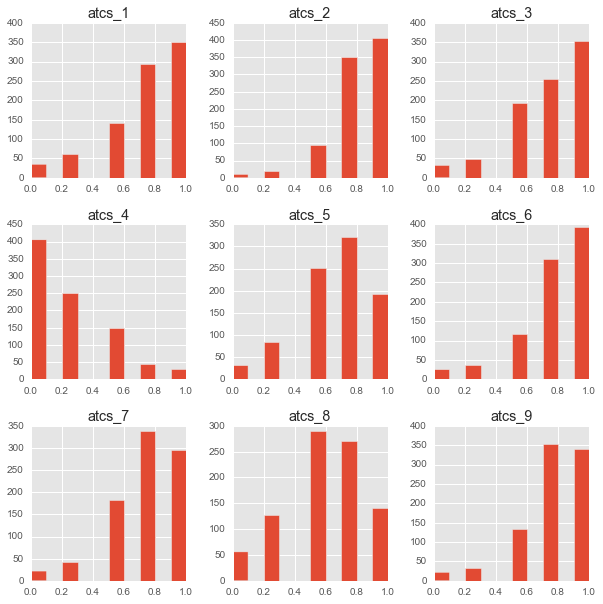

In [64]:
dataset[atcs].hist(figsize=(10, 10));

pyplt.savefig('report/figures/atcs_dimension.pdf', dpi=100)


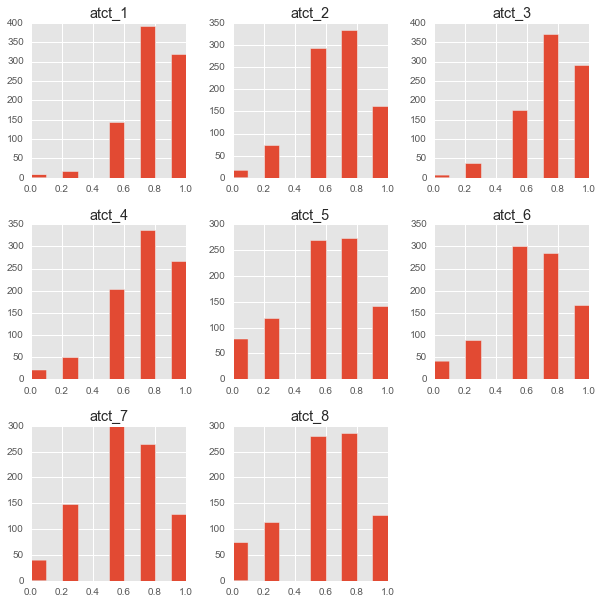

In [65]:
dataset[atct].hist(figsize=(10, 10));

pyplt.savefig('report/figures/atct_dimension.pdf', dpi=100)

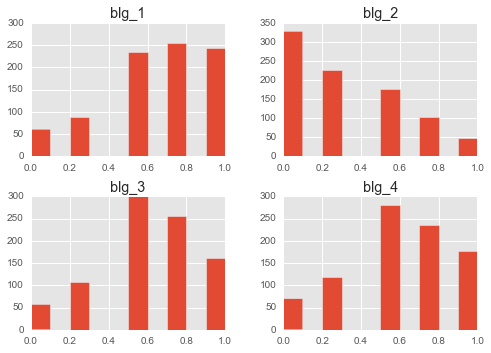

In [68]:
dataset[blg].hist();

pyplt.savefig('report/figures/blg_dimension.pdf', dpi=100)

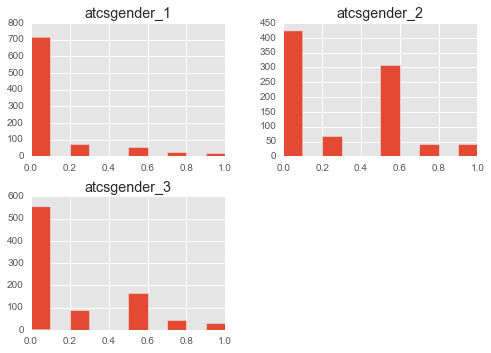

In [69]:
dataset[atcsgender].hist();

pyplt.savefig('report/figures/atcsgender_dimension.pdf', dpi=100)

As we can see, these variables are fairly distributed. 

### Extract features and labels 

Extract feature (X) and target (y) columns

In [12]:
target_col = dataset['gender_Female']  #  column is the target/label 
y = target_col  # corresponding targets/labels

print "\nLabel values:-"
print y.head()  


Label values:-
0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: gender_Female, dtype: float64


In [13]:
X = dataset.drop(['gender_Female', 'gender_Male'], axis=1, inplace=False)

print "\nFeature values:-"
print X.head()  


Feature values:-
   atcs_1  atcs_2  atcs_3  atcs_4  atcs_5  atcs_6  atcs_7  atcs_8  atcs_9  \
0     0.5    0.75    1.00    0.50    0.75    0.75    0.75    0.50    0.75   
1     0.0    0.00    0.00    1.00    0.00    0.00    0.00    0.00    0.25   
2     1.0    1.00    1.00    0.00    1.00    1.00    1.00    1.00    1.00   
3     1.0    0.75    0.75    0.00    0.75    0.75    0.75    1.00    1.00   
4     0.5    0.50    0.75    0.25    0.50    0.75    1.00    0.25    0.75   

   atcsgender_1         ...          mtr_3  prcs_1  prcs_2  prcs_3  prcs_4  \
0           0.0         ...            0.0     0.0     0.0     0.0     0.0   
1           0.0         ...            0.0     0.0     0.0     1.0     1.0   
2           0.0         ...            1.0     0.0     0.0     0.0     0.0   
3           0.0         ...            0.0     0.0     0.0     0.0     0.0   
4           0.0         ...            0.0     0.0     0.0     0.0     0.0   

   prcs_5  prepared  priorcs10  reason_class_Inter

In [14]:
## Make sure we drop the target from the table, otherwise we will be including the labeled data

print "Feature column(s):-", list(X)

Feature column(s):- ['atcs_1', 'atcs_2', 'atcs_3', 'atcs_4', 'atcs_5', 'atcs_6', 'atcs_7', 'atcs_8', 'atcs_9', 'atcsgender_1', 'atcsgender_2', 'atcsgender_3', 'atcsjob_1', 'atcsjob_2', 'atct_1', 'atct_2', 'atct_3', 'atct_4', 'atct_5', 'atct_6', 'atct_7', 'atct_8', 'blg_1', 'blg_2', 'blg_3', 'blg_4', 'classmtr', 'clet_1', 'clet_2', 'cltrcmp_1', 'cltrcmp_2', 'grade_B_or_above', 'grade_B_or_below', 'mtr_1', 'mtr_2', 'mtr_3', 'prcs_1', 'prcs_2', 'prcs_3', 'prcs_4', 'prcs_5', 'prepared', 'priorcs10', 'reason_class_Interested', 'reason_class_Other']


### Determine if classes are balanced
- As we can see the dataset is unbalanced, we have more males than females.




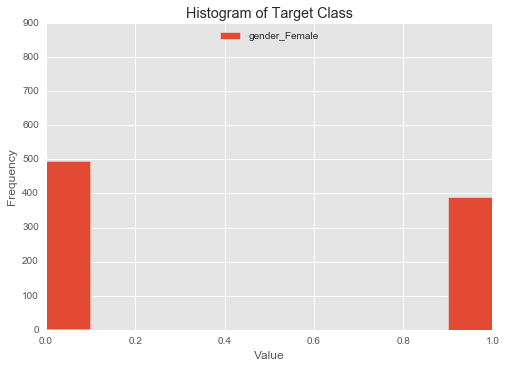

In [15]:
y.plot.hist()

_= pyplt.xlabel('Value')
_= pyplt.title('Histogram of Target Class')
_= pyplt.legend(loc='upper center', shadow=True, fontsize='medium')
_= pyplt.yticks(np.arange(0, 1000, 100))
pyplt.savefig('report/figures/targetClass.pdf', dpi=100)


In [18]:
from __future__ import division

num_male = y.tolist().count(0)
num_female = y.tolist().count(1)


print "number of males in data", num_male
print "number of females in data", num_female


print "ration of males to females {}".format(num_male/ num_female)


number of males in data 494
number of females in data 388
ration of males to females 1.27319587629


## Feature Transformation
We will use principal component analysis (PCA) to draw conclusions about the underlying structure of the data. Since using PCA on a dataset calculates the dimensions which best maximize variance, we will find which compound combinations of features best describe students.

In [19]:
# TODO: Apply PCA by fitting the good data with the same number of dimensions as features
from sklearn.decomposition import PCA

pca_data = dataset.drop(['gender_Female', 'gender_Male'], axis=1, inplace=False)

pca = PCA(n_components=30)
pca.fit(pca_data)


PCA(copy=True, n_components=30, whiten=False)

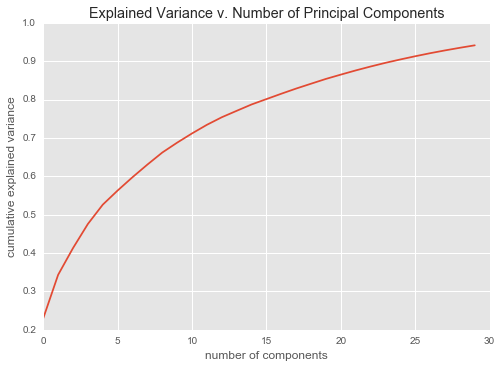

In [20]:
#Explained variance


fig, ax = pyplt.subplots()

_= pyplt.plot(np.cumsum(pca.explained_variance_ratio_))
_= pyplt.title('Explained Variance v. Number of Principal Components')
_= pyplt.xlabel('number of components')
_= pyplt.ylabel('cumulative explained variance')
_= pyplt.show()

fig.savefig('report/figures/explainedVariance.pdf', format='pdf', dpi=100)








In [21]:

print("Projecting the input data on the eigenfaces orthonormal basis")
X_pca = pca.transform(X)

Projecting the input data on the eigenfaces orthonormal basis


In [22]:
X_pca = pd.DataFrame(X_pca)

In [23]:
# First, decide how many training vs test samples you want
num_all = X.shape[0]  # same as len(student_data)
num_train = 662  # about 75% of the data
num_test = num_all - num_train

In [24]:
num_train

662

In [25]:
from sklearn import cross_validation



def shuffle_split_data(X, y):
    """ Shuffles and splits data into 75% training and 25% testing subsets,
        then returns the training and testing subsets. """
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, 
                                                                        train_size=num_train, random_state=42)
    
    
    


    # Return the training and testing data subsets
    return X_train, y_train, X_test, y_test

In [26]:
try:
    X_train, y_train, X_test, y_test = shuffle_split_data(X, y)
    print "Successfully shuffled and split the data!"
except:
    print "Something went wrong with shuffling and splitting the data."


print "Training set: {} samples".format(X_train.shape[0])
print "Test set: {} samples".format(X_test.shape[0])


Successfully shuffled and split the data!
Training set: 662 samples
Test set: 220 samples


In [27]:
X_pca_train, y_pca_train, X_pca_test, y_pca_test = shuffle_split_data(X_pca, y)
print "Training set: {} samples".format(X_pca_train.shape[0])
print "Test set: {} samples".format(X_pca_test.shape[0])

Training set: 662 samples
Test set: 220 samples


## Modeling and Validating




I have created four separate tranches to investigate the data:
- All features
- A reduced dataset of features
- PCA transformed features

## Train on all features

In [28]:
X = X_train

seed = 342 # For reproducability
np.random.seed(seed)
folds = 50

In [29]:

import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import tree
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.learning_curve import validation_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import confusion_matrix



models = {
          'XGBoost': XGBClassifier(),
          'DecisionTree': tree.DecisionTreeClassifier(),
          'SVC': svm.SVC(),
          'RandomForest': RandomForestClassifier()
         }


In [30]:
for model_name, model in models.iteritems():
    print model_name
    kfold = StratifiedKFold(y_train, n_folds=folds, random_state=seed)
    results = cross_val_score(model, X, y_train, cv=kfold)
    print("Training data accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100)), '\n'
   

RandomForest
Training data accuracy: 64.56% (12.63%) 

DecisionTree
Training data accuracy: 60.20% (11.12%) 

XGBoost
Training data accuracy: 67.95% (11.20%) 

SVC
Training data accuracy: 68.14% (11.05%) 



### Predict 

RandomForest
Testing data prediction accuracy: 63.18% 



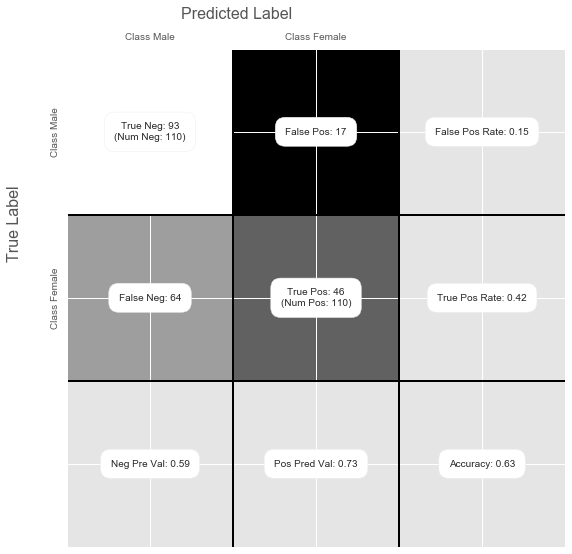

DecisionTree
Testing data prediction accuracy: 61.82% 



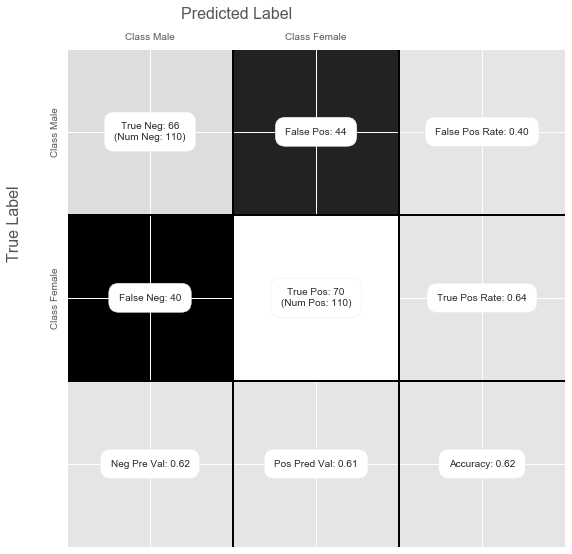

XGBoost
Testing data prediction accuracy: 72.27% 



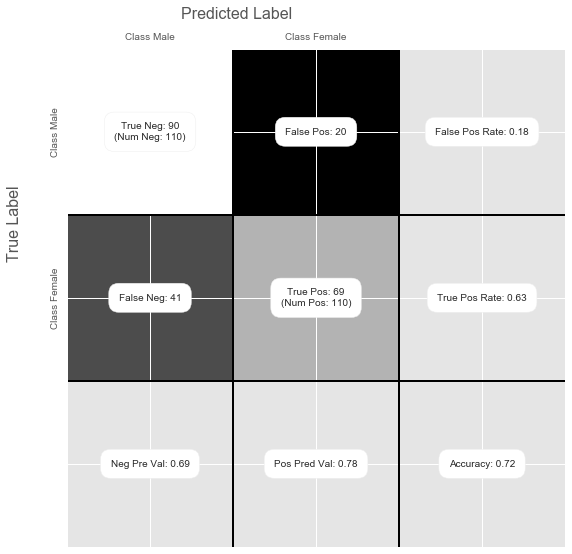

SVC
Testing data prediction accuracy: 64.55% 



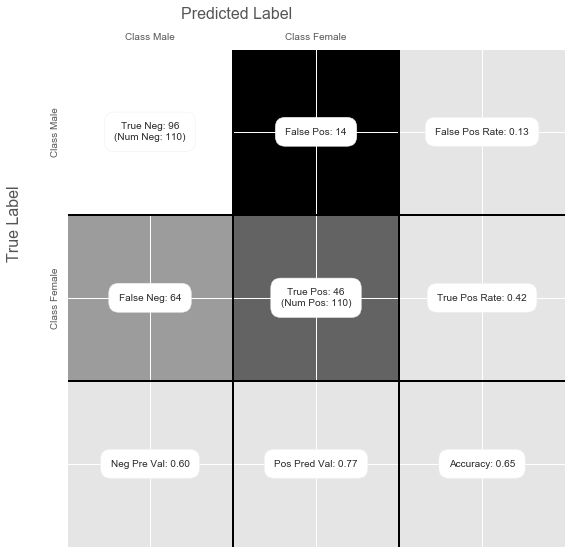

In [87]:
Features_test = X_test

for model_name, model in models.iteritems():
    print model_name
    # make predictions for test data
    model.fit(X, y_train)
    y_pred = model.predict(Features_test)
    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    accuracy = accuracy_score(y_test, predictions)
    print("Testing data prediction accuracy: %.2f%%" % (accuracy * 100.0)), '\n'
    
    C = confusion_matrix(y_test, predictions)
    tools.show_confusion_matrix(C, ['Class Male', 'Class Female'])

### Select XGBoost classifier
- Plot first two xgboost trees to see which features were doing the most work of splitting the data
- Generate Features from XGBoost classifier 

In [53]:
model = XGBClassifier()
model.fit(X, y_train)
g = xgb.to_graphviz(model, num_trees=2, rankdir='LR')
g.render('report/figures/X_graph.gv', view=True)

'report/figures/X_graph.gv.pdf'

### Plot feature importance and test to see if feature results are valid
- Use Chi$^2$   

If the two events are dependent, then the occurrence of the item makes the occurrence of the class
more likely (or less likely), so it should be helpful as a feature. 

- I am only using chi$^2$ scores that are above 18.5, which is the critical value for 0.001 significance given 4 degrees of freedom. These are the features I am considering retaining for the model.

In [55]:
# plot feature importance
from xgboost import plot_importance

def xgb_feature_importance(column_list):

    model = XGBClassifier()
    model.fit(X[column_list], y_train)




    plot_importance(model)
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(14, 8)
    fig.savefig('report/figures/feature_importance_xgb.pdf', dpi=100)

In [56]:

# Used for clean up and realignment as a result of iteratively adding features to classifier to see impact on
# importance.
# [tmp_col.remove(x) for x in validated_features]

In [57]:
tmp_col = list(X.columns)

#### Iteratively select features 
- we wil select top features
- then remove those features from the training set
- rerun the classifier and see which features are now deemed important

We do this several times until we have successfully convinced ourselves we have selected the best set of features based on xgboost feature importance.

In [61]:
item = 'classmtr'

tools.dataLookUp(item)
chi_squared_score, p_value, dof, expected = tools.evaluate_chi(y_train, X[item])
print '\nchi squared score: {:.2f}\np value: {:.12f}\ndegrees of freedom: {:d}'.format(chi_squared_score, p_value, dof)


Our class materials (e.g., case studies and projects) were relevant and practical.

chi squared score: 13.02
p value: 0.011200951459
degrees of freedom: 4


In [62]:
for i in tmp_col:
    chi_squared_score, p_value, dof, expected = tools.evaluate_chi(y_train, X[i])
    
    # The critical value of chi2 statistic for a 0.01 p value with 4 degrees of freedom is 18.

    if chi_squared_score > 18:
        print i
        print 'chi squared score: {:.2f}\np value: {:.12f}\ndegrees of freedom: {:d}\n'.format(chi_squared_score, 
                                                                                p_value, dof)

    

atcs_1
chi squared score: 50.51
p value: 0.000000000282
degrees of freedom: 4

atcs_2
chi squared score: 18.76
p value: 0.000874437708
degrees of freedom: 4

atcs_3
chi squared score: 29.39
p value: 0.000006527467
degrees of freedom: 4

atcs_4
chi squared score: 31.10
p value: 0.000002915197
degrees of freedom: 4

atcs_5
chi squared score: 46.53
p value: 0.000000001909
degrees of freedom: 4

atcs_6
chi squared score: 29.62
p value: 0.000005854108
degrees of freedom: 4

atcs_7
chi squared score: 25.78
p value: 0.000035013193
degrees of freedom: 4

atcs_8
chi squared score: 34.23
p value: 0.000000668036
degrees of freedom: 4

atcsgender_2
chi squared score: 45.22
p value: 0.000000003571
degrees of freedom: 4

atct_5
chi squared score: 59.27
p value: 0.000000000004
degrees of freedom: 4

atct_6
chi squared score: 27.03
p value: 0.000019584104
degrees of freedom: 4

atct_7
chi squared score: 30.23
p value: 0.000004386636
degrees of freedom: 4

atct_8
chi squared score: 59.59
p value: 0.000

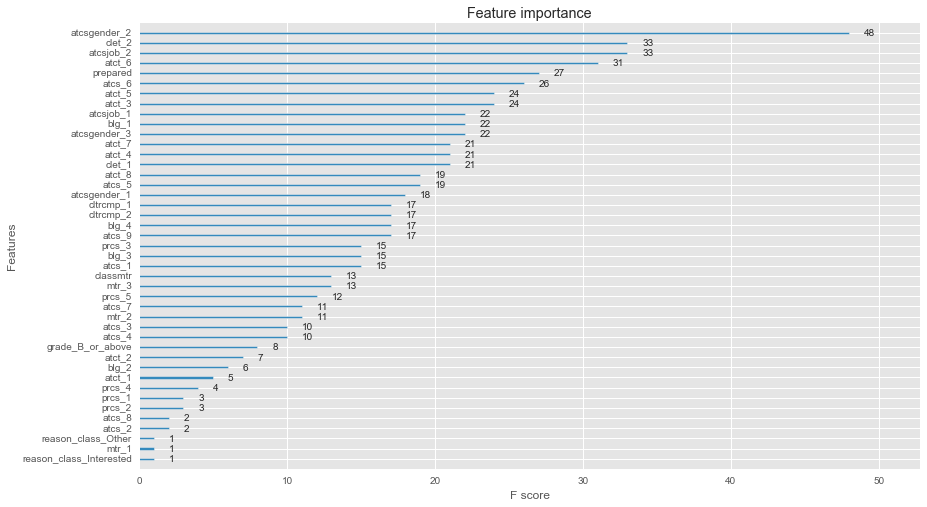

In [63]:
validated_features = ['atcsgender_2', 'atcsjob_2', 'prepared', 'atct_8',
                     'atct_5', 'atcs_5', 'atct_6', 'atcs_7'
                     ] # 'clet_2', 'atct_7', 'atcs_6', 'atcs_1', 'atcs_4' , 'blg_4' , 'classmtr'

# through this cell, I am in
#tmp_col.remove('classmtr')

xgb_feature_importance(tmp_col)

We are just displaying the first two trees here.   

On simple models the first two trees may be enough. XGBoost generate `k` trees at each round for a `k`-classification problem.

In [64]:
model = XGBClassifier()
model.fit(X[validated_features], y_train)
g = xgb.to_graphviz(model, num_trees=2, rankdir='LR')
g.render('report/figures/X_validated_graph.gv', view=True)


y_pred = model.predict(X_test[validated_features])
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Testing data prediction accuracy: %.2f%%" % (accuracy * 100.0)), '\n'

Testing data prediction accuracy: 69.09% 



## Train on a reduced set of features
- We will reduce the number of features used based on feature importance given by xgboost classifier

In [65]:
# Extract feature (X) and target (y) columns

columns_to_model = [
    'atcsgender_2', 'clet_2', 'atcsjob_2', 'atct_6', 'prepared',
    'atcs_6', 'atct_5', 'atct_3', 'atcsjob_1', 'blg_1', 'atcsgender_3',
    'atct_7', 'atct_4', 'clet_1', 'atct_8', 'atcs_5', 'atcsgender_1',
    'cltrcmp_1', 'cltrcmp_2', 'blg_4']

X_all_Reduced = X_train[columns_to_model]


print "\nFeature values:-"
print X_all_Reduced.head()  


Feature values:-
     atcsgender_2  clet_2  atcsjob_2  atct_6  prepared  atcs_6  atct_5  \
292           0.0    0.75       0.00    0.75      0.00    1.00    0.75   
596           0.5    0.50       0.75    0.75      0.50    0.75    0.75   
516           0.0    0.00       0.00    0.50      0.25    1.00    0.75   
447           0.0    0.50       0.00    0.50      0.75    0.75    0.75   
813           0.0    0.75       0.75    0.50      0.25    1.00    0.50   

     atct_3  atcsjob_1  blg_1  atcsgender_3  atct_7  atct_4  clet_1  atct_8  \
292    1.00       0.75   0.75          0.00    0.75    0.75    0.75    0.75   
596    0.75       0.75   0.75          0.25    0.75    0.75    0.75    0.75   
516    0.75       1.00   0.75          0.25    0.75    0.75    0.25    0.75   
447    0.75       1.00   1.00          0.25    0.75    0.75    0.75    0.75   
813    0.50       0.75   0.50          0.00    0.25    0.75    0.75    0.50   

     atcs_5  atcsgender_1  cltrcmp_1  cltrcmp_2  blg_4  
292  

In [66]:
model = XGBClassifier()
print "Training: ", model.__class__.__name__
kfold = StratifiedKFold(y_train, n_folds=folds, random_state=seed)
results = cross_val_score(model, X_all_Reduced, y_train, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100)), '\n'



Training:  XGBClassifier
Accuracy: 68.52% (11.39%) 



In [67]:
Features_test = X_test[columns_to_model]



model.fit(X_all_Reduced, y_train)
y_pred = model.predict(Features_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Testing data prediction accuracy: %.2f%%" % (accuracy * 100.0)), '\n'
print model

Testing data prediction accuracy: 71.82% 

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)


In [68]:
model = XGBClassifier()
model.fit(X_all_Reduced, y_train)
g = xgb.to_graphviz(model, num_trees=2, rankdir='LR')
g.render('report/figures/X_all_Reduced_graph.gv', view=True)

'report/figures/X_all_Reduced_graph.gv.pdf'

## Train on PCA data

In [69]:
model = XGBClassifier()
print "Training: ", model.__class__.__name__
kfold = StratifiedKFold(y_pca_train, n_folds=folds, random_state=seed)
results = cross_val_score(model, X_pca_train, y_pca_train, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100)), '\n'


Training:  XGBClassifier
Accuracy: 66.10% (13.28%) 



In [70]:
model.fit(X_pca_train, y_pca_train)
y_pred = model.predict(X_pca_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_pca_test, predictions)
print("Testing data prediction accuracy: %.2f%%" % (accuracy * 100.0)), '\n'

Testing data prediction accuracy: 66.36% 



# Tune Estimator

### Ideal choices of parameters as taken from Xgboost With Python ebook

- Number of Trees (`n_estimators`) set to a fixed value between 100 and 1000, depending on the dataset size.
- Learning Rate (`learnin_rate`) simplified to the ratio: [2 to 10]/trees, depending on the trees number of trees.
- Row Sampling (`subsample`) grid searched values in the range [0.5, 0.75, 1.0].
- Column Sampling (`colsample` bytree and maybe colsample bylevel) grid searched values in the range [0.4, 0.6, 0.8, 1.0].
- Min Leaf Weight (`min_child_weight`) simplified to the ratio 3/rare_events , where rare events rare events is the percentage of rare event observations in the dataset.
- Tree Size (`max_depth`) grid searched values in the rage [4, 6, 8, 10].
- Min Split Gain (`gamma`) fixed with a value of zero.


In [17]:
X = X_train

NameError: name 'X_train' is not defined

In [42]:
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.metrics import f1_score, make_scorer
from xgboost.sklearn import XGBClassifier



default_params = {
    'objective': 'binary:logistic',
    'max_depth': 1,
    'learning_rate': 0.3
}


n_estimators_range = np.linspace(1, 200, 10).astype('int') 

# Build a stratified shuffle object because of unbalanced data
folds = 50
ssscv = StratifiedShuffleSplit(y_train, folds, random_state=seed)


train_scores, test_scores = validation_curve(
    XGBClassifier(**default_params),
    X, y_train,
    param_name = 'n_estimators',
    param_range = n_estimators_range,
    cv=ssscv,
    scoring='accuracy'
)


 Show the validation curve plot

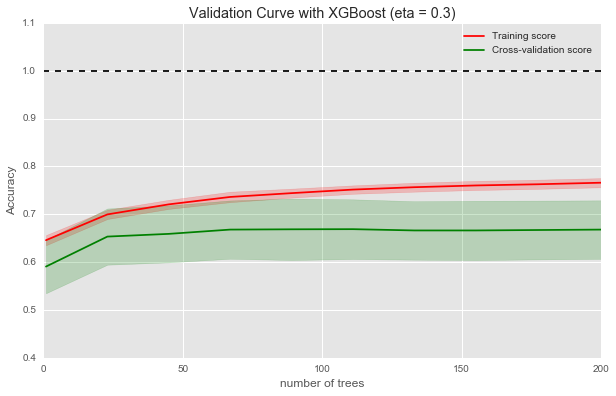

Best cross-validation result (0.67) obtained for 111 trees


In [43]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

fig = plt.figure(figsize=(10, 6), dpi=100)

plt.title("Validation Curve with XGBoost (eta = 0.3)")
plt.xlabel("number of trees")
plt.ylabel("Accuracy")
plt.ylim(0.4, 1.1)

plt.plot(n_estimators_range,
             train_scores_mean,
             label="Training score",
             color="r")

plt.plot(n_estimators_range,
             test_scores_mean, 
             label="Cross-validation score",
             color="g")

plt.fill_between(n_estimators_range, 
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, 
                 alpha=0.2, color="r")

plt.fill_between(n_estimators_range,
                 test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std,
                 alpha=0.2, color="g")

plt.axhline(y=1, color='k', ls='dashed')

plt.legend(loc="best")
plt.show()

i = np.argmax(test_scores_mean)
print("Best cross-validation result ({0:.2f}) obtained for {1} trees".format(test_scores_mean[i], 
                                                                             n_estimators_range[i]))

fig.savefig('report/figures/varianceCurve_1.pdf', format='pdf')


Looking at the plot we can draw the following conclusions:
- training score keeps growing while adding new trees, but from a certain point CV score is fixed
- variance is lowest, and bias is high for less than 25 trees,
- we can see that the model is quite stable keeping variance fixed when increasing it's complexity   

We can assume that the trade-off for our model will be met at n_estimators = 50. The variance is still to big.


Tweak parameters
- To reduce a variance:  
    - each tree we will use 70% randomly chosen samples
    - 60% randomly chosen features   
    
- To decrease the bias (bigger accuracy):
    - Add an extra level to each tree


In [44]:
default_params = {
    'objective': 'binary:logistic',
    'max_depth': 2, # changed
    'learning_rate': 0.3,
    'colsample_bytree': 0.6, # added
    'subsample': 0.7 # added
}

n_estimators_range = np.linspace(1, 200, 10).astype('int')

train_scores, test_scores = validation_curve(
    XGBClassifier(**default_params),
    X, y_train,
    param_name = 'n_estimators',
    param_range = n_estimators_range,
    cv=ssscv,
    scoring='accuracy'
)

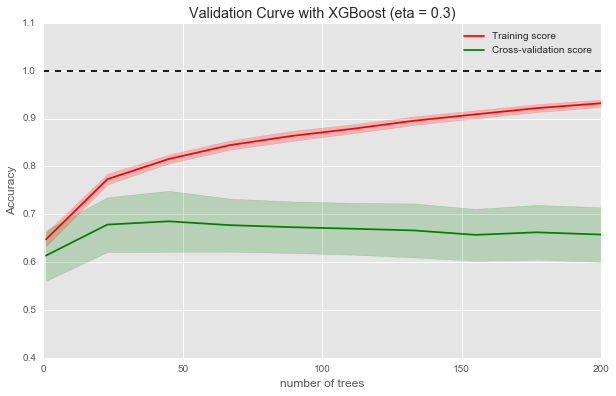

Best cross-validation result (0.69) obtained for 45 trees


In [45]:

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

fig = plt.figure(figsize=(10, 6), dpi=100)

plt.title("Validation Curve with XGBoost (eta = 0.3)")
plt.xlabel("number of trees")
plt.ylabel("Accuracy")
plt.ylim(0.4, 1.1)
plt.plot(n_estimators_range,
             train_scores_mean,
             label="Training score",
             color="r")

plt.plot(n_estimators_range,
             test_scores_mean, 
             label="Cross-validation score",
             color="g")

plt.fill_between(n_estimators_range, 
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, 
                 alpha=0.2, color="r")

plt.fill_between(n_estimators_range,
                 test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std,
                 alpha=0.2, color="g")

plt.axhline(y=1, color='k', ls='dashed')

plt.legend(loc="best")
plt.show()

i = np.argmax(test_scores_mean)
print("Best cross-validation result ({0:.2f}) obtained for {1} trees".format(test_scores_mean[i], 
                                                                             n_estimators_range[i]))
fig.savefig('report/figures/varianceCurve_2.pdf', format='pdf')

In [46]:
params_grid = {
            'learning_rate': [0.2222, 0.4444, 0.6666, 0.8888],
            'max_depth': [4, 6, 8, 10],
            'n_estimators': range(100, 1100, 100),
            'colsample_bytree': [0.6],
            'subsample':[0.7]
}

params_fixed = {
    'objective': 'binary:logistic',
    'silent': 1
}

In [82]:
# Load and use already tuned classifier, else tune classifier

tune_flag = False

if tune_flag:
    grid = GridSearchCV(estimator=XGBClassifier(**params_fixed),
        param_grid=params_grid,
        cv=ssscv,
        scoring='accuracy')
    grid.fit(X, y_train)
    
    print "Best accuracy obtained: {0}".format(grid.best_score_)
    print "Parameters:"
    for key, value in grid.best_params_.items():
        print "\t{}: {}".format(key, value)
    model = grid.best_estimator_
    
    # save model to file
    pickle.dump(model, open("genderedCSExperience.pickle.dat", "wb"))
    
else:    
    model = tools.load_model()
    print model

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.6,
       gamma=0, learning_rate=0.2222, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=nan, n_estimators=200, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=1, subsample=0.7)


In [83]:
Features_test = X_test

# make predictions for test data
model.fit(X, y_train)
y_pred = model.predict(Features_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 75.91%


In [84]:
model.fit(X, y_train)
g = xgb.to_graphviz(model, num_trees=2, rankdir='LR')
g.render('report/figures/Tuned_model_graph.gv', view=True)

'report/figures/Tuned_model_graph.gv.pdf'

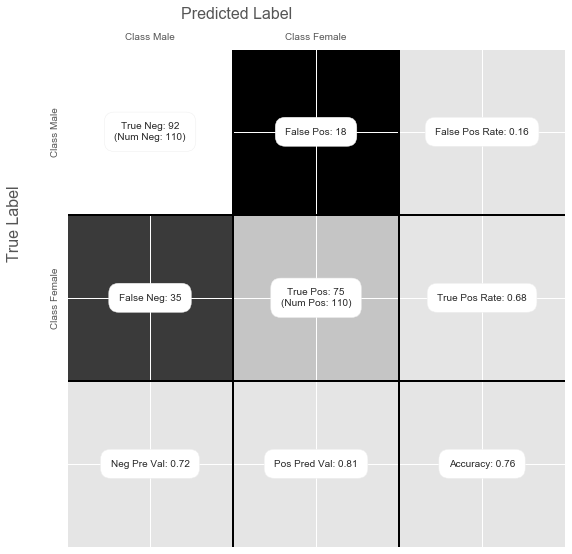

In [85]:
C = confusion_matrix(y_test, predictions)
tools.show_confusion_matrix(C, ['Class Male', 'Class Female'])